In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
with open("combined_cleaned.txt", "r", encoding="utf-8") as f:
    data = f.read()

chars = sorted(list(set(data)))
vocab_size = len(chars)
print(f"Vocabulary Size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

data_encoded = np.array([stoi[ch] for ch in data], dtype=np.int64)

# Split data: 90% for training, 10% for validation
split_index = int(len(data_encoded) * 0.9)
train_data = data_encoded[:split_index]
val_data = data_encoded[split_index:]
print(f"Training data length: {len(train_data)}")
print(f"Validation data length: {len(val_data)}")


Vocabulary Size: 305
Training data length: 4442307
Validation data length: 493590


In [3]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embed = nn.Embedding(vocab_size, hidden_size)
        # You can later add dropout here if desired (e.g., dropout=0.2)
        self.rnn = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden):
        x = self.embed(x)  # (batch, seq_len, hidden_size)
        out, hidden = self.rnn(x, hidden)
        # Flatten output for the fully connected layer
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc(out)  # (batch*seq_len, vocab_size)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

# Hyperparameters
hidden_size = 256      
num_layers = 1
lr = 0.003
batch_size = 64
seq_length = 100
num_epochs = 10

# Initialize model, loss function, and optimizer
model = CharRNN(vocab_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [4]:
# Lists to record average training and validation losses per epoch
train_losses = []
val_losses = []

def get_batch(data, batch_size, seq_length):
    """Randomly sample batch of sequences and targets from given data."""
    indices = np.random.randint(0, len(data) - seq_length - 1, batch_size)
    x_batch = np.array([data[i:i+seq_length] for i in indices])
    y_batch = np.array([data[i+1:i+seq_length+1] for i in indices])
    return (torch.tensor(x_batch, dtype=torch.long).to(device),
            torch.tensor(y_batch, dtype=torch.long).to(device))

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    hidden = model.init_hidden(batch_size)
    total_loss = 0
    num_batches = len(train_data) // (batch_size * seq_length)
    
    for i in range(num_batches):
        inputs, targets = get_batch(train_data, batch_size, seq_length)
        hidden = hidden.detach()  # detach hidden state
        
        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)
        loss = criterion(outputs, targets.view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{num_batches}], Loss: {loss.item():.4f}")
    
    avg_train_loss = total_loss / num_batches
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Training Loss: {avg_train_loss:.4f}")
    
    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        num_val_batches = len(val_data) // (batch_size * seq_length)
        for j in range(num_val_batches):
            val_inputs, val_targets = get_batch(val_data, batch_size, seq_length)
            # Initialize validation hidden state for consistency
            val_hidden = model.init_hidden(batch_size)
            outputs, val_hidden = model(val_inputs, val_hidden)
            val_loss = criterion(outputs, val_targets.view(-1))
            total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / num_val_batches if num_val_batches > 0 else 0
        val_losses.append(avg_val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Validation Loss: {avg_val_loss:.4f}")

print("Training complete.")


Starting training...
Epoch [1/10], Batch [100/694], Loss: 1.8851
Epoch [1/10], Batch [200/694], Loss: 1.6849
Epoch [1/10], Batch [300/694], Loss: 1.6434
Epoch [1/10], Batch [400/694], Loss: 1.6011
Epoch [1/10], Batch [500/694], Loss: 1.5751
Epoch [1/10], Batch [600/694], Loss: 1.6076
Epoch [1/10] Average Training Loss: 1.7233
Epoch [1/10] Average Validation Loss: 1.5086
Epoch [2/10], Batch [100/694], Loss: 1.5092
Epoch [2/10], Batch [200/694], Loss: 1.4759
Epoch [2/10], Batch [300/694], Loss: 1.5423
Epoch [2/10], Batch [400/694], Loss: 1.4288
Epoch [2/10], Batch [500/694], Loss: 1.5116
Epoch [2/10], Batch [600/694], Loss: 1.4279
Epoch [2/10] Average Training Loss: 1.4868
Epoch [2/10] Average Validation Loss: 1.4322
Epoch [3/10], Batch [100/694], Loss: 1.4277
Epoch [3/10], Batch [200/694], Loss: 1.5029
Epoch [3/10], Batch [300/694], Loss: 1.4171
Epoch [3/10], Batch [400/694], Loss: 1.4686
Epoch [3/10], Batch [500/694], Loss: 1.4258
Epoch [3/10], Batch [600/694], Loss: 1.4170
Epoch [3/10

Model saved as 'char_rnn_model.pth'.

Generated Sample Text:
the birl and then every spatic. radisa who understanding the crew that, it was all discles down to your ha view all vieber by develope is any yearn thing/community at the lipment from your just quite about growing up the eed im. the facm that i was inevitably to things feel?’
yeah, you know, you guys get and diegine?
nightmades
is ben still uniquends and particulation ones to feel a bumpen building all bessols in.
got a few years afraid by each other for the extending up 27 videos i thought and reco


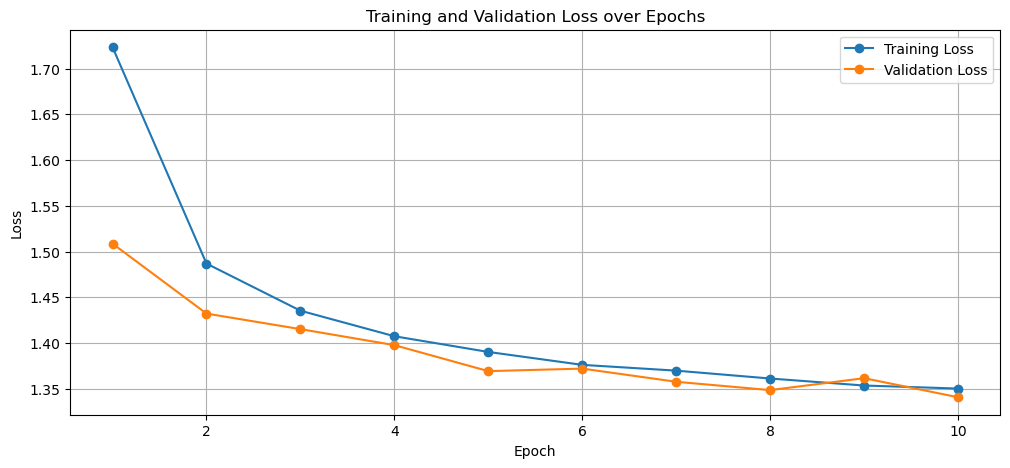

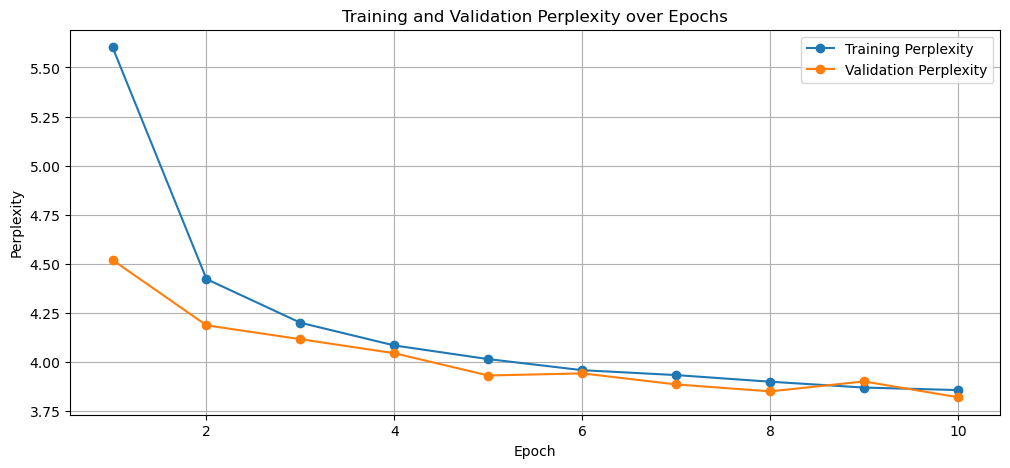

In [5]:
# Save the trained model
torch.save(model.state_dict(), "char_rnn_model.pth")
print("Model saved as 'char_rnn_model.pth'.")

def generate_text(model, start_text="the ", length=300, temperature=1.0):
    start_text = start_text.lower()
    chars_generated = list(start_text)
    hidden = model.init_hidden(1)
    input_seq = torch.tensor([[stoi[ch] for ch in start_text if ch in stoi]], dtype=torch.long).to(device)
    
    _, hidden = model(input_seq, hidden)
    
    last_char = input_seq[0, -1]
    for _ in range(length):
        output, hidden = model(last_char.view(1, 1), hidden)
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        char = itos[top_i.item()]
        chars_generated.append(char)
        last_char = torch.tensor([stoi[char]], dtype=torch.long).to(device)
    return "".join(chars_generated)

sample_text = generate_text(model, start_text="The ", length=500)
print("\nGenerated Sample Text:")
print(sample_text)

with open("lvl1_output.txt", "w", encoding="utf-8") as f:
    f.write(sample_text)

# Plot training loss, validation loss, and perplexity over epochs
epochs = np.arange(1, len(train_losses) + 1)
train_perplexities = [np.exp(loss) for loss in train_losses]
val_perplexities = [np.exp(loss) for loss in val_losses]

plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss_over_epochs.png")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(epochs, train_perplexities, marker='o', label='Training Perplexity')
plt.plot(epochs, val_perplexities, marker='o', label='Validation Perplexity')
plt.title('Training and Validation Perplexity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(True)
plt.savefig("perplexity_over_epochs.png")
plt.show()
